C:\Users\theye\Anaconda3\envs\ml_project\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


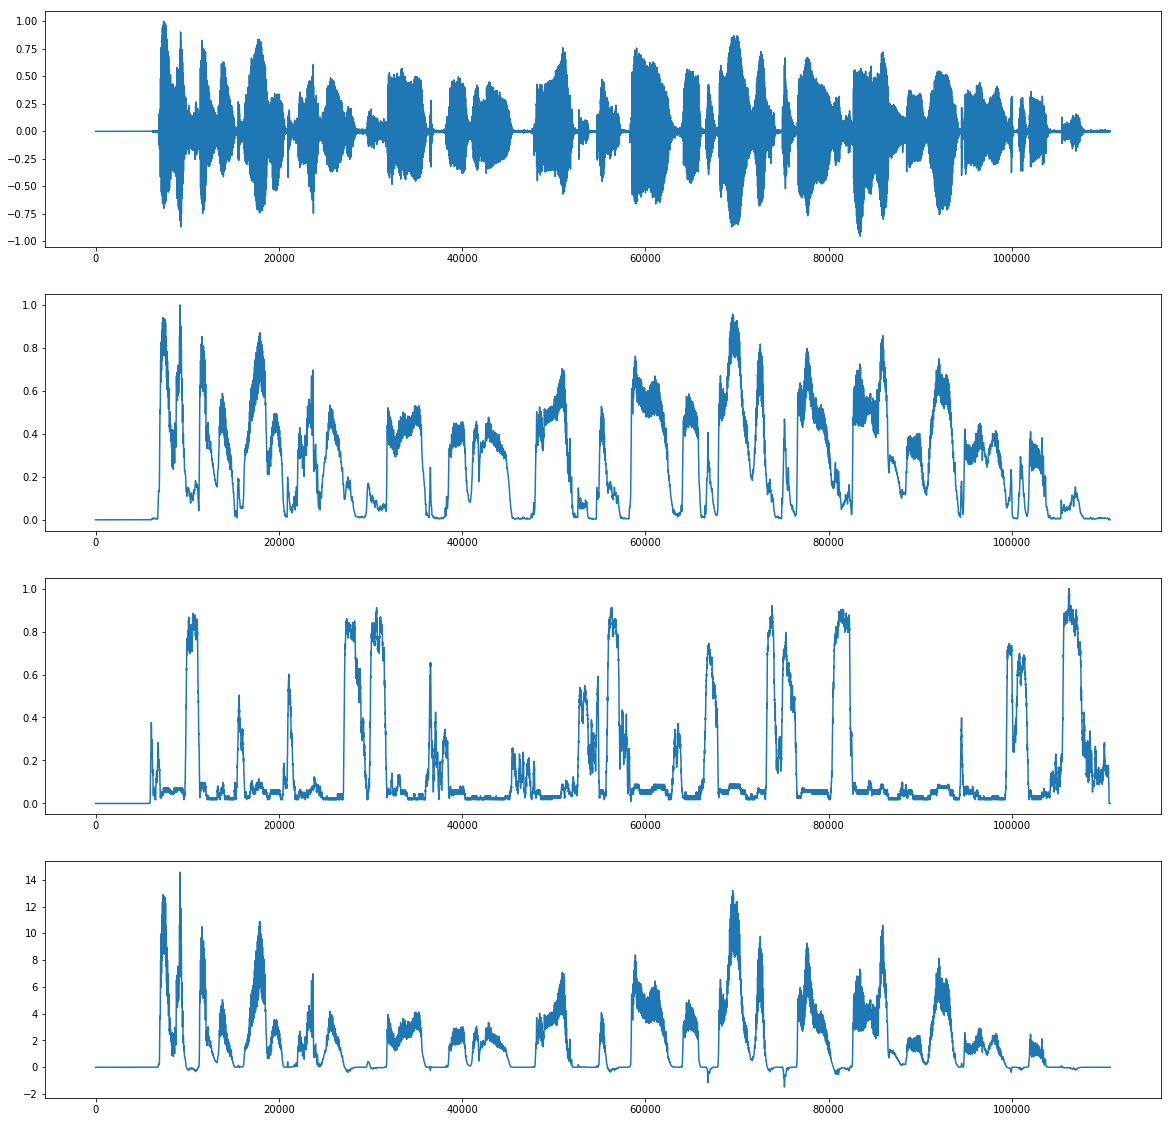

In [3]:
from scipy.signal import chebwin, hanning, savgol_filter, hilbert
from scipy.io import wavfile
from listen.audio.segmentation import segments
import IPython.display
# from listen.spectrogram.spectrogram import Spectrogram
%matplotlib inline
# from listen.data.librispeech import librispeech
from listen.data.an4 import an4
import matplotlib.pyplot as plt
import numpy as np
import listen
    
an4data = an4.AN4(conversion=False, debug=False)

# spg = Spectrogram(fft_size=2048, step_size=128, thresh=400)

# samples, t = list(an4data.trainset)[466]
# samples,t = librispeech.load_data(dev=True)[15]
samples = 'D:\\theyenaman\\Dropbox\\code\\python\\ml_project\\listen\\data\\librispeech\\LibriSpeech\\dev-clean\\84\\121123\\84-121123-0020.wav'
rate, data = wavfile.read(samples)

# spec = spg.compute_spectrum(data.astype(np.float32), logscale=True)

win_len = int((rate * 8) // 1000)
energy = np.zeros_like(data)
acr = np.zeros_like(data)
zcr = np.zeros_like(data)

window = hanning(win_len)

for i in range(len(energy) - win_len):
    energy[i] = np.linalg.norm((data[i:i + win_len] * window), 2) / win_len

data = data / np.max(data)

for i in range(len(zcr) - win_len - 1):
    zcr[i] = np.sum(np.abs(np.sign(data[i:i+win_len]) - np.sign(data[i + 1 : i + win_len + 1])))
    i += win_len // 8

for i in range(len(acr) - 2*win_len):
    acr[i] = np.sum((data[i:i+win_len] * window) * (data[i + 1 : i + win_len + 1] * window))

_en, _zc, _acr = segments(data, rate)
# for i in range(len(zcr) - win_len):
#     es = (data[i:i + win_len] * window) ** 2
#     entropy[i] = np.sum(-e * np.log(e) if e != 0 else 0 for e in es)
#     i += win_len // 8
    
# energy = savgol_filter(energy, win_len + 1, 1)
# zcr = savgol_filter(zcr, win_len + 1, 1)
# entropy = savgol_filter(entropy, win_len + 1, 1)

# m = np.max(energy)
# level = 10
# energy[energy <= (m / level)] = 0
# energy[energy > (m / level)] = 1

fig, ax = plt.subplots(nrows=4,ncols=1, figsize=(20, 20))
ax[0].plot(data / np.max(data), label='Audio')
# ax[1].plot(energy / np.max(energy), label='Windowed Energy')
ax[1].plot(_en, label='Seg-En')
# ax[3].plot(zcr / np.max(zcr), label='Zero Crossing Rate')
ax[2].plot(_zc, label='Seg-Zero Crossing Rate')
# ax[5].plot(acr, label='Seg-Zero Crossing Rate')
ax[3].plot(_acr)
plt.legend()
plt.show()
IPython.display.Audio(data=data, rate=rate)